In [248]:
import PIL

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from os import listdir as ls
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import albumentations as A
from albumentations.pytorch import ToTensor
plt.ion()

In [2]:
df = pd.read_csv('../dataset/chestnet_labels_sample.csv')
df.head()

,Name,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,IsPathology
0,00000013_005.png,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1
1,00000013_026.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,00000017_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,00000032_001.png,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 16 columns):
Name                  5606 non-null object
Atelectasis           5606 non-null int64
Cardiomegaly          5606 non-null int64
Effusion              5606 non-null int64
Infiltration          5606 non-null int64
Mass                  5606 non-null int64
Nodule                5606 non-null int64
Pneumonia             5606 non-null int64
Pneumothorax          5606 non-null int64
Consolidation         5606 non-null int64
Edema                 5606 non-null int64
Emphysema             5606 non-null int64
Fibrosis              5606 non-null int64
Pleural_Thickening    5606 non-null int64
Hernia                5606 non-null int64
IsPathology           5606 non-null int64
dtypes: int64(15), object(1)
memory usage: 700.8+ KB


In [4]:
df.iloc[1, 1:-1].values.astype(int)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [5]:
image_name = df.iloc[67,0]
image_name = os.path.join('../dataset/images', image_name)
img = Image.open(image_name)
print(img)
img = np.array(img)
img.shape

<PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x7F82ADA33128>


(1024, 1024)

In [264]:
class ChestnetDataset(Dataset):
    """Chest X-ray picture dataset annotated with patologies"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        
#         image = io.imread(img_name)
#         image = np.stack([image,image,image], axis = -1)
        
        image = cv2.imread(img_name)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        labels = self.df.iloc[idx, 1:-1].values.astype(int)
        sample = {'image': image, 'labels': labels}

        if self.transform:
            # Apply tranform to numpy.ndarray which represents sample image
#             sample['image'] = self.transform(sample['image'])
            augmented = self.transform(image=sample['image'])
            sample['image'] = augmented['image']

        return sample
    
def show_example(example):
    """
    Show image with labels
    Args:
    example: dict or image(ndarray)
    """
    plt.figure()
    if isinstance(example, dict):
        image = example['image']
        plt.title(str(example['labels']))
    else:
        image = example
    plt.imshow(image)
    plt.show()    

In [265]:
ds = ChestnetDataset('../dataset/chestnet_labels_sample.csv', '../dataset/images/')

img_name = os.path.join('../dataset/images/',
                                '00000032_001.png')
image = ds[9]['image']
image.shape

(1024, 1024, 3)

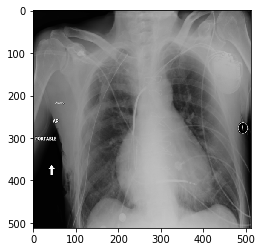

In [267]:
scale = Rescale(512)
show_example(scale(ds[1]['image']))



In [271]:
albumentations_transform = A.Compose([
    A.Resize(560, 560), 
    A.RandomCrop(512, 512),
    A.HorizontalFlip(),
#     A.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     ),
    ToTensor()
])



transformed_dataset = ChestnetDataset('../dataset/chestnet_labels_sample.csv', '../dataset/images/',
                                           transform=albumentations_transform
                                     )

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['labels']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    print('Batch shape', images_batch.size())

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

0 torch.Size([4, 3, 512, 512]) torch.Size([4, 14])
1 torch.Size([4, 3, 512, 512]) torch.Size([4, 14])
Batch shape torch.Size([4, 3, 512, 512])


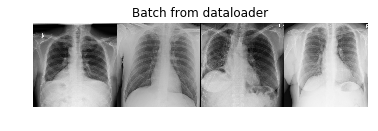

In [285]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['labels'].size())

    # observe 4th batch and stop.
    if i_batch == 1:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break